In [3]:
from glob import glob
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")

In [4]:
import sys
sys.path.append('..')
from src.mod_plot import *
from src.mod_stat import *
from src.mod_spectral import *

from src.mod_interp import *

In [5]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

<div class="alert alert-info" role="alert">

<h2>0. Parameters</h2>

</div>

In [ ]:
time_min = '2019-01-01'                                        # time min for analysis
time_max = '2019-12-31'                                        # time max for analysis
output_dir = '../results'                                      # output directory path
os.system(f'mkdir -p {output_dir}')
stat_output_filename = f'{output_dir}/stat_uv_15m_glorys12v1.nc'   # output statistical analysis filename
psd_output_filename = f'{output_dir}/psd_uv_15m_glorys12v1.nc'     # output spectral analysis filename
segment_lenght =  np.timedelta64(40, 'D')                      # spectral parameter: drifters segment lenght in days to consider in the spectral analysis

<div class="alert alert-info" role="alert">

<h2>1. Input files</h2>

</div>

## [Sea Surface currents from Drifters database](https://doi.org/10.17882/86236)

In [7]:
#filenames_drifters = sorted(glob('/work/ALT/swot/aval/wisa/data_challenge_ose/data/independent_drifters/uv_drifters_*.nc'))
filenames_drifters = sorted(glob('../data/independent_drifters/uv_drifters_*.nc'))

In [8]:
ds_drifter = xr.open_mfdataset(filenames_drifters, combine='nested', concat_dim='time')
ds_drifter = ds_drifter.where((ds_drifter.time >= np.datetime64(time_min)) & (ds_drifter.time <=  np.datetime64(time_max)), drop=True)
#ds_drifter = ds_drifter.rename({'EWCT': 'uo'})
#ds_drifter = ds_drifter.rename({'NSCT': 'vo'})
ds_drifter



<xarray.Dataset>
Dimensions:    (time: 2156405)
Coordinates:
  * time       (time) datetime64[ns] 2019-01-01 ... 2019-12-31
    latitude   (time) float32 dask.array<chunksize=(5559,), meta=np.ndarray>
    longitude  (time) float32 dask.array<chunksize=(5559,), meta=np.ndarray>
Data variables:
    EWCT       (time) float32 dask.array<chunksize=(5559,), meta=np.ndarray>
    NSCT       (time) float32 dask.array<chunksize=(5559,), meta=np.ndarray>
    sensor_id  (time) float64 dask.array<chunksize=(5559,), meta=np.ndarray>
Attributes: (12/46)
    data_type:                   OceanSITES trajectory data
    format_version:              2.0
    platform_code:               116275
    date_update:                 2020-10-13T12:17:40Z
    institution:                 AOML
    institution_edmo_code:       1799
    ...                          ...
    deployment_lat:              -58.44
    last_longitude_observation:  82.75
    last_latitude_observation:   -18.49
    date_drog_lost:              2017-01-21T03:37:00Z
    death_type:                  stop transmitting
    last_date_observation:       2019-01-16T01:51:00Z

## Sea Surface current maps to evaluate

In [10]:
#list_of_maps = sorted(glob('/work/ALT/swot/aval/wisa/data_challenge_ose/data/maps/GLORYS12v1_allsat/*.nc'))
list_of_maps = "/Odyssey/private/t22picar/data/glorys_15m/glorys_15.81m_2019-01-01-2020-01-01.nc"
ds_maps = xr.open_mfdataset(list_of_maps, combine='nested', concat_dim='time')
#ds_maps = ds_maps.drop_vars("depth")
ds_maps = ds_maps.sel(time=slice(time_min, time_max),depth=ds_maps.depth[0])
ds_maps = ds_maps.rename({'uo': 'ugos'})
ds_maps = ds_maps.rename({'vo': 'vgos'})
ds_maps

<xarray.Dataset>
Dimensions:    (latitude: 2041, longitude: 4320, time: 365)
Coordinates:
    depth      float32 15.81
  * latitude   (latitude) float32 -80.0 -79.92 -79.83 ... 89.83 89.92 90.0
  * longitude  (longitude) float32 -180.0 -179.9 -179.8 ... 179.8 179.8 179.9
  * time       (time) datetime64[ns] 2019-01-01 2019-01-02 ... 2019-12-31
Data variables:
    mlotst     (time, latitude, longitude) float32 dask.array<chunksize=(365, 2041, 4320), meta=np.ndarray>
    ugos       (time, latitude, longitude) float32 dask.array<chunksize=(365, 2041, 4320), meta=np.ndarray>
    vgos       (time, latitude, longitude) float32 dask.array<chunksize=(365, 2041, 4320), meta=np.ndarray>
    zos        (time, latitude, longitude) float32 dask.array<chunksize=(365, 2041, 4320), meta=np.ndarray>
    thetao     (time, latitude, longitude) float32 dask.array<chunksize=(365, 2041, 4320), meta=np.ndarray>
Attributes:
    Conventions:               CF-1.4
    comment:                   CMEMS product
    institution:               MERCATOR OCEAN
    references:                http://www.mercator-ocean.fr
    title:                     daily mean fields from Global Ocean Physics An...
    source:                    MERCATOR GLORYS12V1
    history:                   2023/06/01 16:20:05 MERCATOR OCEAN Netcdf crea...
    copernicusmarine_version:  2.0.1

<div class="alert alert-info" role="alert">

<h2>2. Statistical & Spectral Analysis </h2>

</div>

## 2.1 Interpolate sea surface currents maps onto drifters positions

In [11]:
ds_interp = run_interpolation_drifters(ds_maps, ds_drifter, time_min, time_max)
ds_interp = ds_interp.dropna('time')
ds_interp = ds_interp.sortby('time')
ds_interp


2025-04-17 10:36:55 INFO     fetch data from 2019-01-01 00:00:00 to 2019-02-01 00:00:00
2025-04-17 10:38:34 INFO     fetch data from 2019-01-01 00:00:00 to 2019-02-01 00:00:00
2025-04-17 10:39:39 INFO     fetch data from 2019-01-31 00:00:00 to 2019-03-01 00:00:00
2025-04-17 10:39:49 INFO     fetch data from 2019-01-31 00:00:00 to 2019-03-01 00:00:00
2025-04-17 10:39:58 INFO     fetch data from 2019-02-28 00:00:00 to 2019-04-01 00:00:00
2025-04-17 10:40:07 INFO     fetch data from 2019-02-28 00:00:00 to 2019-04-01 00:00:00
2025-04-17 10:40:17 INFO     fetch data from 2019-03-31 00:00:00 to 2019-05-01 00:00:00
2025-04-17 10:40:26 INFO     fetch data from 2019-03-31 00:00:00 to 2019-05-01 00:00:00
2025-04-17 10:40:35 INFO     fetch data from 2019-04-30 00:00:00 to 2019-06-01 00:00:00
2025-04-17 10:40:45 INFO     fetch data from 2019-04-30 00:00:00 to 2019-06-01 00:00:00
2025-04-17 10:40:54 INFO     fetch data from 2019-05-31 00:00:00 to 2019-07-01 00:00:00
2025-04-17 10:41:03 INFO     fet

<xarray.Dataset>
Dimensions:            (time: 2124693)
Coordinates:
  * time               (time) datetime64[ns] 2019-01-01 ... 2019-12-31
Data variables:
    EWCT               (time) float32 -0.1013 -0.1692 ... -0.04298 -0.07795
    NSCT               (time) float32 0.2415 0.00305 ... 0.03121 -0.1021
    sensor_id          (time) float64 1.163e+05 1.164e+05 ... 6.831e+07
    latitude           (time) float32 -20.17 -23.35 -29.47 ... -16.64 -32.11
    longitude          (time) float32 87.07 -6.986 -12.2 ... 86.61 121.6 95.08
    ugos_interpolated  (time) float64 -0.05 0.0677 0.08562 ... 0.03202 -0.04081
    vgos_interpolated  (time) float64 0.2081 -0.2543 ... 0.06543 -0.01976

In [12]:
ds_drifter

<xarray.Dataset>
Dimensions:    (time: 2156405)
Coordinates:
  * time       (time) datetime64[ns] 2019-01-01 ... 2019-12-31
    latitude   (time) float32 dask.array<chunksize=(5559,), meta=np.ndarray>
    longitude  (time) float32 dask.array<chunksize=(5559,), meta=np.ndarray>
Data variables:
    EWCT       (time) float32 dask.array<chunksize=(5559,), meta=np.ndarray>
    NSCT       (time) float32 dask.array<chunksize=(5559,), meta=np.ndarray>
    sensor_id  (time) float64 dask.array<chunksize=(5559,), meta=np.ndarray>
Attributes: (12/46)
    data_type:                   OceanSITES trajectory data
    format_version:              2.0
    platform_code:               116275
    date_update:                 2020-10-13T12:17:40Z
    institution:                 AOML
    institution_edmo_code:       1799
    ...                          ...
    deployment_lat:              -58.44
    last_longitude_observation:  82.75
    last_latitude_observation:   -18.49
    date_drog_lost:              2017-01-21T03:37:00Z
    death_type:                  stop transmitting
    last_date_observation:       2019-01-16T01:51:00Z

## 2.2 Compute grid boxes statistics & statistics by regime (coastal, offshore low variability, offshore high variability)

In [13]:
# Compute gridded stats
compute_stat_scores_uv(ds_interp, stat_output_filename)

2025-04-17 10:44:24 INFO     Compute mapping error all scales
2025-04-17 10:44:24 INFO     Compute statistics
2025-04-17 10:44:27 INFO     Stat file saved as: ../results/stat_uv_0m_glorys12v1.nc
2025-04-17 10:44:27 INFO     Compute statistics by oceanic regime


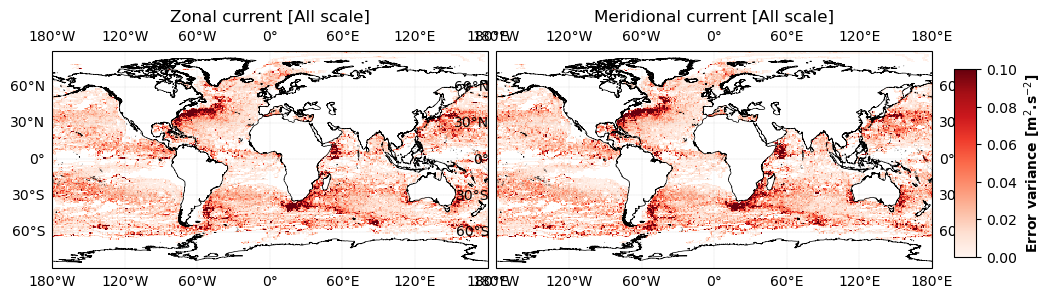

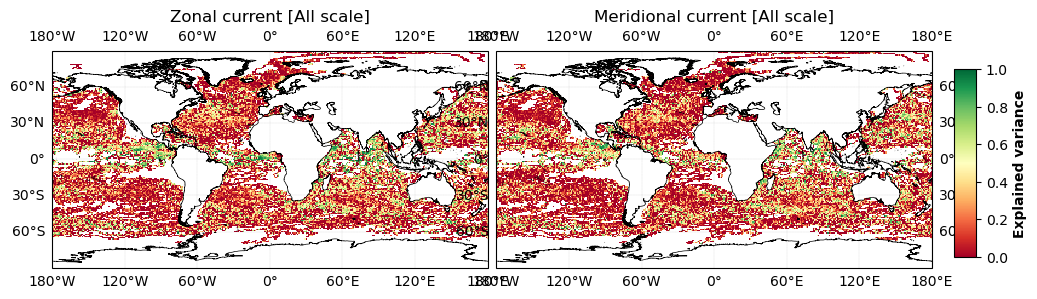

In [14]:
# Plot gridded stats
# Hvplot
# plot_stat_score_map_uv(stat_output_filename)
# Matplotlib
plot_stat_score_map_uv_png(stat_output_filename)

The figure shows that the maximum mapping errors are found in intense current systems, for example in the GulfStream, Kuroshio and Agulhas regions. 

However, when considering the full scale of motion in the drifter database, the surface current maps capture up to 80% of the variability of drifter currents in the Western Boundary Currents and Antarctic Circumpolar Currents (ACC). The geostrophic signal dominates the ageostrophic signal in these regions. In regions with low ocean variability, only a few percent of the total drifter current variability is recovered in the maps, which may be associated with a larger ageostrophic signal in these regions.

In [15]:
plot_stat_uv_by_regimes(stat_output_filename)

,mapping_err_u_var [m²/s²],mapping_err_v_var [m²/s²],ugos_interpolated_var [m²/s²],EWCT_var [m²/s²],vgos_interpolated_var [m²/s²],NSCT_var [m²/s²],var_score_u_allscale,var_score_v_allscale
coastal,0.032721,0.029079,0.028238,0.055471,0.026678,0.046011,0.410112,0.368010
offshore_highvar,0.072422,0.073107,0.105401,0.137618,0.098566,0.119880,0.473745,0.390166
offshore_lowvar,0.026365,0.023095,0.020886,0.043289,0.016356,0.030865,0.390956,0.251751
equatorial_band,0.038554,0.030780,0.070921,0.106864,0.038370,0.058053,0.639225,0.469792
arctic,0.016495,0.018130,0.005480,0.017227,0.005575,0.018082,0.042487,-0.002622
antarctic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2.3 Compute Spectral scores

We propose here to reproduce the Figure 2 of <a href="https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2007GL032874">Elipot and Lumpkin (2008)</a>  which gives a spectral description of oceanic near-surface variability, and investigate the spectral error and spectral coherence by latitunial band. 

In [16]:
# Compute PSD scores
compute_psd_scores_current(ds_interp, psd_output_filename, lenght_scale=segment_lenght)

2025-04-17 11:01:58 INFO     Segment computation...
2025-04-17 11:02:59 INFO     Spectral analysis...
2025-04-17 11:02:59 INFO     Write output...
2025-04-17 11:02:59 INFO     PSD file saved as: ../results/psd_uv_0m_glorys12v1.nc


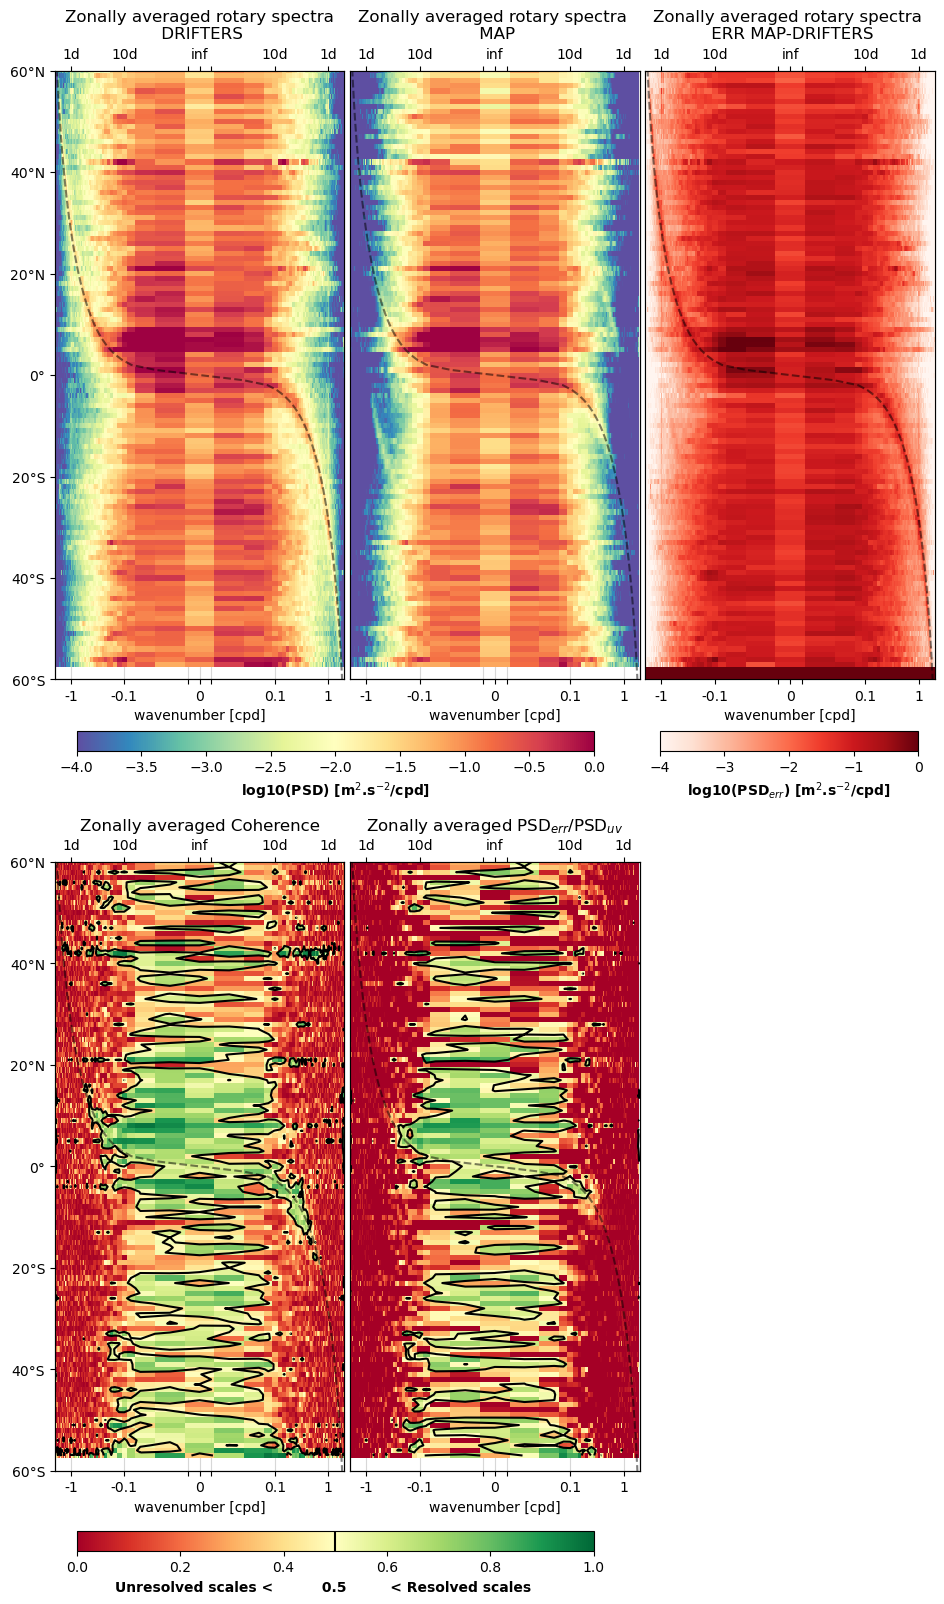

In [17]:
# Plot Zonally averaged rotary spectra
# Hvplot
# plot_psd_scores_currents(psd_output_filename)
# Matplotlib
plot_psd_scores_currents_png(psd_output_filename)

In [18]:
# Plot Zonally averaged rotary spectra
plot_psd_scores_currents_1D(psd_output_filename)

ModuleNotFoundError: No module named 'jupyter_bokeh'

:Layout
   .DynamicMap.I  :DynamicMap   [lat]
   .DynamicMap.II :DynamicMap   [lat]

The interactive plot above allows you to explore the spectral metrics by latitude band